For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week12-word-context-vectors

# Hist 3368 - Week 12: Word Context Vectors - OPTIONAL

#### By Jo Guldi

#### From Word Vectors to Word Context Vectors

In previous notebooks, you've used word count vectors to compare the words most distinctive of companies and time periods, and to measure the abstract "distance" between different entities.

In our reading, we've learned that many scholars applied word vectors to understanding intellectual history. Word vectors can help you to understand the changing profile of every word -- how its "context" was different in 1920 than in 1980.  For example, the word "gay" meant "happy" in 1920, but by 1990 it had come to mean "homosexual."  Word context is the study of the changing words that surrounded "gay" in both instances.

Wordcount vectors can get you to changing word context. To perform such an investigation, you need to structure the data so that there is one vector for each word in every period of time.  This is called a “word context vector”. 

In this week's notebook, we'll make word context vectors for some words in Congress. We'll go through the following steps:
* First, we'll organize the data so that we have a dataframe of one word per row, where another column gives the sentence in which the word appears in Congress and the date.
* Then, we'll "groupby" keyword and period, so that we have an index for each keyword and period (for instance, "woman-1985") and a "context" column with every word next to which "woman" appears in the year 1985.
* Next, we'll use the word vector tools you already know -- SKLEARN's Countvectorizer(), .fit_transform -- to make vectors from this data.
* We'll use a measurement tool you already know -- cosine distance -- to compare context vectors for "woman" from 1985 to 1995 and 2005
* We'll use a comparison tool you already know -- vector subtraction -- to create a "gender difference vectors" whose low scores show words more likely to show up in the context of "woman" and whose high scores show words more likely to show up in the context of "man"
* Later in the notebook, we'll return to a 'word embedding' software package that uses high-dimensional math and hidden layers to make whip-fast vectors.

#### Word Vectors vs. Word Embeddings 

Wordcount vectors are just what we’ve looked at: a simple count of words, with one integer per every word.  Wordcount embeddings are similar. But they typically add one more row of data or more per document.  That might mean that there’s a count of how many nouns, verbs, or adjectives there are per document. That might mean that there’s a count of bigrams, trigrams, fourgrams, or more – or multi-word phrases, plus or minus a word, called a “skipgram.”  These “hidden layers” in word embedding models mean an even richer model of which documents are like other documents. Because they factor in grammar and sentence structure as well as lexicon, they produce models that are very good at matching rhetorical style in text, and getting at the nuances of grammatical meaning. That is to say, they’re good at noticing when you mean “apple” the fruit (which you might eat or make into pie) or “apple” the computer (which you might turn on or off).  

Functionally, you use word embeddings just the way you use wordcount vectors. You can measure the distance between them, just like we did in our notebook this week.  You can subtract them, just as we did, to get a litmus test of what’s different between two periods of time, or which words are used to signify masculinity and femininity.  

*In the first half of this notebook,* we'll stick with "word vectors," not embeddings.  We'll word context vectors 'by hand' -- i.e., using onyl SKLEARN's CountVectorizer() and .fit_transform + cosine distance and subtraction.  Doing it this way is slower than loading some other packages that have been built specifically for working with large-scale wordcount vectors, where the code is packaged with high-dimensional math designed to make the comparisons run faster. We're doing it this way, however, so that you can really see for yourself how a word vector is built and what's inside it at every moment.   When we structure the data, build the vectors, subtract and measure the distance between vectors, we'll be able to inspect what's in the vector at every turn. You'd be able to do the math yourself if you looked more carefully.

*In the second half of the code,* however, we'll use the GENSIM package of word embeddings to work on a larger-scale sample of debates. We'll use GENSIM's pre-built tools to do analysis comparative to what you did with cosine distance and vector subtraction:

     wv.vocab - which allows you to inspect the words in a vector 
     wv.most_similar() - which allows you to call up vectors from your dataset that are most similar to a given word

#### Skill Building for Historical Analysis

By the end of this notebook, you'll know how to replicate most of the fancy work with vectors in the reading.  You'll be able to:
* use word context vectors to analyze the intellectual history of concept words like "freedom," "gay", or "woman," detecting how their context changed from moment to moment
* visualize changes to word concepts as a dendrogram
* use GENSIM's "most_similar()" to generate a list of the words most similar to any concept (for instance "freedom") at different moments over time
* visualize changes to the context of an individual word over time

### Loading data

In [1]:
import pandas as pd
import csv
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

The following lines load some data from Congress. Don't worry too much about the commands within this block; we're more interested in the transformations we'll apply to the data after it's loaded.  If you're curious, the lines below download two separate dataframes --  "speeches" and "descriptions" -- and then merge them  so that we now have one database of speeches with the date on which they were spoken.

In [2]:
all_speech_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_*.txt')
CONGRESS_MIN_THRESHOLD = 100
CONGRESS_MAX_THRESHOLD = 115

speech_files = []

for fn in all_speech_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        speech_files.append(fn)

speech_files.sort()
        
def parse_one(fn):
    print(f'Reading {fn}...')
    return pd.read_csv(fn, sep='|', encoding="ISO-8859-1", error_bad_lines=False, warn_bad_lines=False, quoting=csv.QUOTE_NONE)

speeches_df = pd.concat((parse_one(fn) for fn in speech_files))
speeches_df.dropna(how='any', inplace=True)

all_description_files = glob.glob('/scratch/group/oit_research_data/stanford_congress/hein-bound/descr_*.txt')
                                  
description_files = []

for fn in all_description_files:
    number = int(fn.rsplit('_', 1)[-1].split('.')[0])
    if CONGRESS_MIN_THRESHOLD <= number <= CONGRESS_MAX_THRESHOLD:
        description_files.append(fn)
        description_files.sort()
        
description_df = pd.concat((parse_one(fn) for fn in description_files))

all_data = pd.merge(speeches_df, description_df, on = 'speech_id')
all_data.fillna(0, inplace=True)
all_data = all_data.drop(['chamber', 'speech_id', 'number_within_file', 'speaker', 'first_name'], 1)
all_data = all_data.drop(['last_name', 'state', 'gender', 'line_start', 'line_end', 'file', 'char_count', 'word_count'], 1)
all_data['date']=pd.to_datetime(all_data['date'],format='%Y%m%d')
all_data['year'] = pd.to_datetime(all_data['date']).dt.year

Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_100.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_101.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_102.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_103.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_104.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_105.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_106.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_107.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_108.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_109.txt...
Reading /scratch/group/oit_research_data/stanford_congress/hein-bound/speeches_110.txt...
Reading /s

In [3]:
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year'], 1)

In [4]:
all_data.head()

,speech,5yrperiod
0,Representativeselect to the 100th Congress. th...,1985.0
1,The Chair would also like to state that Repres...,1985.0
2,The quor closes that 426 Represe have answered...,1985.0
3,The Clerk credentials regular in for received ...,1985.0
4,The next order of business is the election of ...,1985.0


#### Downsample

In this exercise, the first pass, we're going to do some memory-intensive work on the computer by creating word context vectors 'by hand' -- i.e., using onyl SKLEARN's CountVectorizer() and .fit_transform + cosine distance and subtraction.  

Doing it this way is slower than loading some other packages that have been built specifically for working with large-scale wordcount vectors, where the code is packaged with high-dimensional math designed to make the comparisons run faster.

We're doing it this way, however, so that you can really see for yourself how a word vector is built and what's inside it at every moment.   

When we structure the data, build the vectors, subtract and measure the distance between vectors, we'll be able to inspect what's in the vector at every turn. You'd be able to do the math yourself if you looked more carefully.

Later in the notebook, we'll return to a 'word embedding' software package that uses high-dimensional math and hidden layers to make whip-fast vectors.

However, as we're doing old-fashioned vectors by hand, it'll go best if we "downsample" the data, taking a random sample of 5000 sentences spoken in Congress between 1985-2010.

Let's create some downsamples so we don't break the computer.

In [5]:
sample_l = all_data.sample(500000)
sample_m = sample_l.sample(50000)
sample = sample_m.sample(5000)

### Structure the data

We want to make a word context vector dataframe.

First, we'll break up the data so that we have one row per every sentence.

Then, we'll break up the data so that we have one row per every word -- and a column with the 'sentence' where the word was originally found.

This will tell us about the context of the word.

We'll retain information about the '5yrperiod' when the word was originally from.

#### Break data into sentences

Here's a handy script for breaking up strings into sentences.

In [6]:
tokenizer = TreebankWordTokenizer()

def make_sentences(text):
    preprocessed_text = []
    for line in text:
        lower_case = line.lower()
        sentences = sent_tokenize(lower_case)
        tokenized_sentences = [tokenizer.tokenize(sent) for sent in sentences]
        preprocessed_text += tokenized_sentences
    return preprocessed_text

Apply the make_sentences function to the 'speech' column (this might take a while):

In [7]:
sentences = make_sentences(sample['speech']).copy()
sentences[:2]

[['i',
  'ask',
  'unanimous',
  'consent',
  'that',
  'the',
  'pending',
  'committee',
  'amendment',
  'be',
  'laid',
  'aside',
  '.'],
 ['the',
  'following',
  'senators',
  'are',
  'necessarily',
  'absent',
  ':',
  'the',
  'senator',
  'from',
  'texas',
  'and',
  'the',
  'senator',
  'from',
  'arizona',
  '.']]

In [8]:
word_context_sentences = pd.concat([pd.DataFrame({'sentence': speech, '5yrperiod': row['5yrperiod']}, index=[0]) 
           for _, row in sample.iterrows() 
           for speech in row['speech'].split('.') if speech != ''])
word_context_sentences

,sentence,5yrperiod
0,I ask unanimous consent that the pending commi...,1990.0
0,The following Senators are necessarily absent:...,2010.0
0,Just for 1 moment,1985.0
0,I am not saying that at all,1985.0
0,because even if the bill had come to the floo...,1985.0
...,...,...
0,"I am confident that Garr ""Mike"" King will bri...",1995.0
0,S,1995.0
0,District Court for the district of Oregon the...,1995.0
0,professionalism,1995.0


#### Break sentences into words

Here's some code for breaking up sentences into words.

Create an 'index' column with 
    
        np.arange(len(index_context))

In [9]:
index_context = word_context_sentences.copy()
index_context['index'] = np.arange(len(index_context)) # create an 'index' column
index_context

,sentence,5yrperiod,index
0,I ask unanimous consent that the pending commi...,1990.0,0
0,The following Senators are necessarily absent:...,2010.0,1
0,Just for 1 moment,1985.0,2
0,I am not saying that at all,1985.0,3
0,because even if the bill had come to the floo...,1985.0,4
...,...,...,...
0,"I am confident that Garr ""Mike"" King will bri...",1995.0,97560
0,S,1995.0,97561
0,District Court for the district of Oregon the...,1995.0,97562
0,professionalism,1995.0,97563


Use str.split() and 

    .explode()

to create a dataframe with one word per row

In [10]:
word_per_row = index_context.set_index('index')
word_per_row =pd.concat([word_per_row['sentence'].str.split(' ').explode()],axis=1).reset_index() #explode the data 
word_per_row = word_per_row.rename({'sentence' : 'keyword'}, axis = 1) # rename the column "sentence" to "keyword"
word_per_row

,index,keyword
0,0,I
1,0,ask
2,0,unanimous
3,0,consent
4,0,that
...,...,...
945060,97564,exemplified
945061,97564,his
945062,97564,entire
945063,97564,legal


Merge the two dataframes to create a well-annotated dataframe of every word and its context.

In [11]:
word_context_words = pd.merge(word_per_row, index_context, on="index") # merge the two df's
word_context_words = word_context_words.drop('index', 1) # get rid of the index column because we don't need it any more
word_context_words

,keyword,sentence,5yrperiod
0,I,I ask unanimous consent that the pending commi...,1990.0
1,ask,I ask unanimous consent that the pending commi...,1990.0
2,unanimous,I ask unanimous consent that the pending commi...,1990.0
3,consent,I ask unanimous consent that the pending commi...,1990.0
4,that,I ask unanimous consent that the pending commi...,1990.0
...,...,...,...
945060,exemplified,and integrity that has exemplified his entire...,1995.0
945061,his,and integrity that has exemplified his entire...,1995.0
945062,entire,and integrity that has exemplified his entire...,1995.0
945063,legal,and integrity that has exemplified his entire...,1995.0


In [12]:
word_context_words['keyword'] = word_context_words['keyword'].str.strip() # strip the whitespace
word_context_words

,keyword,sentence,5yrperiod
0,I,I ask unanimous consent that the pending commi...,1990.0
1,ask,I ask unanimous consent that the pending commi...,1990.0
2,unanimous,I ask unanimous consent that the pending commi...,1990.0
3,consent,I ask unanimous consent that the pending commi...,1990.0
4,that,I ask unanimous consent that the pending commi...,1990.0
...,...,...,...
945060,exemplified,and integrity that has exemplified his entire...,1995.0
945061,his,and integrity that has exemplified his entire...,1995.0
945062,entire,and integrity that has exemplified his entire...,1995.0
945063,legal,and integrity that has exemplified his entire...,1995.0


You can use 

    .size()
    
with .groupby() to get the word counts per time.  We can also call

    .to_frame()

to tell pandas what to name the new column

In [13]:
words_per_period = word_context_words.groupby(['keyword', '5yrperiod']).size().to_frame('count')
words_per_period

count
keyword 5yrperiod       
        1985.0     10869
        1990.0     19112
        1995.0     21196
        2000.0     17206
        2005.0     18881
...                  ...
zones   2005.0         1
       1990.0         1
        2000.0         1
        2005.0         1
§       2005.0        14

[75637 rows x 1 columns]

#### Groupby Word and Period

Let's create a new data structure where we group by keyword AND period.

If we organize our data this way, we will preserve information about the context for how each word was spoken about, across all companies, in 1994, 2011, etc.  



Technically, we could groupby('keyword', '5yrperiod'). However, later on, we're going to want to call vectors of data by an index that references both word and period. So it's better if we just create a new column for the data called 'wpord-period,' and groupby() that.

In [14]:
word_context_word_period = word_context_words.copy()
word_context_word_period['word-period'] = word_context_word_period['keyword'] + "-" + word_context_word_period['5yrperiod'].astype(str)
word_context_word_period = word_context_word_period.drop(['5yrperiod', 'keyword'], 1)
word_context_word_period

,sentence,word-period
0,I ask unanimous consent that the pending commi...,I-1990.0
1,I ask unanimous consent that the pending commi...,ask-1990.0
2,I ask unanimous consent that the pending commi...,unanimous-1990.0
3,I ask unanimous consent that the pending commi...,consent-1990.0
4,I ask unanimous consent that the pending commi...,that-1990.0
...,...,...
945060,and integrity that has exemplified his entire...,exemplified-1995.0
945061,and integrity that has exemplified his entire...,his-1995.0
945062,and integrity that has exemplified his entire...,entire-1995.0
945063,and integrity that has exemplified his entire...,legal-1995.0


In [15]:
word_context_grouped = word_context_word_period.groupby(['word-period']).sum()

In [16]:
word_context_grouped

,sentence
word-period,
!-1990.0,! Let us talk about this effort of fairness
!-1995.0,I ask unanimous consent that th( ! oclock hou...
!erwise-1995.0,The White House was able to bring the power o...
!ncreased-1985.0,Our current tax incentives for employerassist...
!s-2005.0,This !s not a vote to deploy an MX force tota...
...,...
zones-2005.0,and buffer zones to protect rivers and stream...
-1990.0,under the regime of Roe versus Wade 
-2000.0,THOMAS: Add at the end the following new titl...


In this new output, the 'context' column has all the words from all the sentences that contain the 'keyword' of that row in a given period. 

In [17]:
word_context_grouped.filter(like = 'woman', axis=0)

,sentence
word-period,
Chairwoman-2005.0,Chairwoman WATERS
Congresswoman-1985.0,I also commend Congresswoman LINDY BOGGS and ...
Congresswoman-1990.0,Senator or Congressman or Congresswoman more ...
Congresswoman-1995.0,Congressman PATRICK KENNEDY and Congresswoman...
Congresswoman-2000.0,Congresswoman DUNN and myself brought to thei...
Congresswoman-2005.0,along with Congresswoman DIANA DEGETTE and Co...
Congresswoman-2010.0,I want to thank Congresswoman TITUS for intro...
chairwoman-2005.0,the chairwoman for the Subcommittee on Middle...
gentlewoman-1985.0,the gentlewoman from Louisiana is recognized ...


We're now ready to see how 'woman' changed its meaning in Congress from 1985 to 2005.

## Make Word Context Vectors

In [18]:
vectorizer = CountVectorizer(max_features=10000, lowercase=True, ngram_range=(1, 1), analyzer = "word")

Note that we feed the vectorizer the column 'sentence' because we want to model the CONTEXT in which each keyword appears.

In [19]:
vectorized = vectorizer.fit_transform(word_context_grouped['sentence'])

Inspect the vectors as a dataframe where every column is a word and every row a period:

In [20]:
context_words = np.array(vectorizer.get_feature_names())
context_words

array(['000', '10', '100', ..., 'zero', 'zone', 'zones'], dtype='<U20')

In [21]:
word_period = list(word_context_grouped.axes[0].to_numpy())
word_period[:10]

['!-1990.0',
 '!-1995.0',
 '!erwise-1995.0',
 '!ncreased-1985.0',
 '!s-2005.0',
 '"$30-1995.0',
 '"$341-1995.0',
 '"$344-1995.0',
 '"(1)-1995.0',
 '"(2)-1995.0']

In [22]:
vectors_dataframe = pd.DataFrame(vectorized.todense(), # the matrix we saw above is turned into a dataframe
                                 columns=context_words,
                                 index = word_period
                                 )
vectors_dataframe

,000,10,100,1000,1002,100th,101,101st,102,104th,...,youre,yourself,youth,youths,yucca,yugoslavia,ywca,zero,zone,zones
!-1990.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!-1995.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!erwise-1995.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!ncreased-1985.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!s-2005.0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zones-2005.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-1990.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-2000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-2005.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
matr = vectorized.todense()
matr

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Taking measurements of vectors

In our last exercise, we measured how different individual words were from each other.

Let's do it again.

In [24]:
woman_1985_vector = vectors_dataframe.filter(regex = ('^woman-1985'), axis=0) # the caret (^) means 'begins with'
woman_1985_vector 

,000,10,100,1000,1002,100th,101,101st,102,104th,...,youre,yourself,youth,youths,yucca,yugoslavia,ywca,zero,zone,zones
woman-1985.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
woman_1990_vector = vectors_dataframe.filter(regex = '^woman-1990', axis=0)
woman_1995_vector = vectors_dataframe.filter(regex = '^woman-1995', axis=0)
woman_2000_vector = vectors_dataframe.filter(regex = '^woman-2000', axis=0)
woman_2005_vector = vectors_dataframe.filter(regex = '^woman-2005', axis=0)
woman_1990_vector

,000,10,100,1000,1002,100th,101,101st,102,104th,...,youre,yourself,youth,youths,yucca,yugoslavia,ywca,zero,zone,zones
woman-1990.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The vectors_dataframe is nice to use because its rows and columns are nicely labeled.  It's easy to call exactly the keyword-period combination you want.  

You can use the rows directly pulled from vectors_dataframe as the basis for calculating cosine distances.

In [26]:
scipy.spatial.distance.cosine(woman_1985_vector, woman_1990_vector)

0.26464683948772694

In [27]:
scipy.spatial.distance.cosine(woman_1985_vector, woman_1995_vector)

0.23674635860809523

In [28]:
scipy.spatial.distance.cosine(woman_1985_vector, woman_2000_vector)

0.34751438691710745

In [29]:
scipy.spatial.distance.cosine(woman_1985_vector, woman_2005_vector)

0.3149670281873208

#### Subtracting vectors

Above, we called the rows of vectors_dataframe directly to calculate cosine distances.  

We can use these same vectors to execute a subtraction -- with a bit of reformatting.

First, we "transmute" them from a horizontal row of values to a vertical row of values with 

    .T


Next, we call the columns with the values by name, e.g.: 

    ['woman-1985.0']


In [30]:
diff = woman_1995_vector.T['woman-1995.0'] - woman_1985_vector.T['woman-1985.0']
diff

000           0
10            0
100           0
1000          0
1002          0
             ..
yugoslavia    0
ywca          0
zero          0
zone          0
zones         0
Length: 10000, dtype: int64

We "sort" the values from small to big using:

    .sort_values()



In [31]:
diff.sort_values()

abortion   -3
right      -2
not        -2
an         -2
generous   -1
           ..
to          3
that        4
woman       6
the         6
and         7
Length: 10000, dtype: int64

Hint: use 
    
    .dropna() 
    
to get rid of NaN's (not a number)

In [32]:
diff.dropna().sort_values()

abortion   -3
right      -2
not        -2
an         -2
generous   -1
           ..
to          3
that        4
woman       6
the         6
and         7
Length: 10000, dtype: int64

These are the words that changed the most in the context of 'woman' between 1985 and 1995.

## Compare words used for 'man' and 'woman'

Let's make a vector that contains all the references to women.

In [33]:
pattern = ['woman','women','\bshe','\bher','\bhers','girl']
woman_vector = vectors_dataframe.loc[[x for x in vectors_dataframe.index for word in pattern if word in x]]

woman_vector

,000,10,100,1000,1002,100th,101,101st,102,104th,...,youre,yourself,youth,youths,yucca,yugoslavia,ywca,zero,zone,zones
"""womens-2000.0",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
654women-1985.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chairwoman-2005.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Congresswoman-1985.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Congresswoman-1990.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Congresswoman-1995.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Congresswoman-2000.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Congresswoman-2005.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Congresswoman-2010.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HIVwomen-1990.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That's the data we want, all right. But it'd be more useful as a matrix where all the columns are added together. 

That's easy to do with 

    .sum()

In [34]:
woman_vector = woman_vector.sum()
woman_vector

000           0
10            1
100           0
1000          0
1002          0
             ..
yugoslavia    0
ywca          0
zero          1
zone          0
zones         0
Length: 10000, dtype: int64

Perfect! Now let's look for men

In [35]:
import re
pattern2 = ['\bhe\b','\bhim','\bhis','\bman\b','\bmen\b','boy\b','boys']
man_vector = vectors_dataframe.loc[[x for x in vectors_dataframe.index for word in pattern2 if word in x]]
man_vector = man_vector.sum()
man_vector

000           0
10            0
100           0
1000          0
1002          0
             ..
yugoslavia    0
ywca          0
zero          0
zone          0
zones         0
Length: 10000, dtype: int64

In [36]:
gender_diff_vector = man_vector - woman_vector

In [37]:
gender_diff_vector.sort_values()

the         -792
and         -491
women       -426
to          -396
of          -362
            ... 
ancestors      1
grow           1
younger        1
likes          1
boys           9
Length: 10000, dtype: int64

The output of gender_diff_vector.sort_values() is predictive of the words most likely to refer to women (the negatives) and the words most likely to indicate men (the higher positives.)

## Word Embeddings

At this point in the code, we're shifting from word vectors made with SKLEARN to word "embeddings" made with the GENSIM package.

GENSIM uses higher-level math to condense the matrices, meaning that we'll be able to deal with more information than the downsized sample above. Word embeddings like GENSIM also typically have a "hidden layer" of modeling which includes information about word order and part-of-speech, designed to make the word vectors more accurate models of the way that words are used in sentences. 

In [38]:
import gensim 

#### Resample the data and create data structure (again)

Let's use a larger sample than we did last time. We'll need to break it into sentences and words again, and group by the features of the data that we care about -- keyword and period -- again.

Because you've seen the instructions above, we'll skip them below and just give the code.

NOTE: the lines below may take a while. Splitting sentences and words can be intensive on a dataset of this scale. If it's not working for you, try sample_m or sample where you see sample_l in the first line.

In [39]:
sample_l

,speech,5yrperiod
2484822,The Senator from New Mexico is recognized. (Th...,2005.0
225994,Mr. Chairman. I yield myself 3 minutes. Mr. Ch...,1985.0
2576474,The Senator from South Dakota is recognized.,2005.0
2348245,Mr. Speaker. I move to suspend the rules and a...,2005.0
1862596,Madam Speaker. as one of the 435 Members of th...,2000.0
...,...,...
1511149,Mr. Chairman. I yield myself the balance of my...,1995.0
2259849,Madam Speaker. Whereas. Mrs. Smith has shown a...,2005.0
806821,Mr. President. I wish to speak just very brief...,1990.0
523935,As the gentleman knows. we are bound by tradit...,1990.0


In [40]:
sentences_m = make_sentences(sample_m['speech']).copy() # <---- switch out sample_l to sample_s or sample_m here
word_context_sentences_m = pd.concat([pd.DataFrame({'sentence': speech, '5yrperiod': row['5yrperiod']}, index=[0]) 
           for _, row in sample.iterrows() 
           for speech in row['speech'].split('.') if speech != ''])

In [41]:
sentences_m[:2]

[['mr.', 'president', '.'],
 ['i',
  'thank',
  'the',
  'chairman',
  'and',
  'ranking',
  'member',
  'of',
  'the',
  'subcommittee',
  'on',
  'transportation',
  'that',
  'they',
  'will',
  'protect',
  'my',
  'concerns',
  'in',
  'conference',
  'with',
  'respect',
  'to',
  'the',
  '``',
  'buy',
  'america',
  "''",
  'statute',
  '.']]

We're now ready to model a larger set of data in Congress from 1985 to 2005 with the help of GENSIM.

#### Break sentences into words (for later use)

Here's the code for breaking up sentences into words. We'll need words_per_period later in the code. You've seen the detailed code before, so here's the quick version.

In [42]:
index_context2 = word_context_sentences_m.copy()
index_context2['index'] = np.arange(len(index_context2)) # create an 'index' column
word_per_row2 = index_context2.set_index('index')
word_per_row2 =pd.concat([word_per_row2['sentence'].str.split(' ').explode()],axis=1).reset_index() #explode the data 
word_per_row2 = word_per_row2.rename({'sentence' : 'keyword'}, axis = 1) # rename the column "sentence" to "keyword"
word_context_words2 = pd.merge(word_per_row2, index_context2, on="index") # merge the two df's
word_context_words2 = word_context_words2.drop('index', 1) # get rid of the index column because we don't need it any more
word_context_words2['keyword'] = word_context_words2['keyword'].str.strip() # strip the whitespace
words_per_period2 = word_context_words2.groupby(['keyword', '5yrperiod']).size().to_frame('count')
words_per_period2

count
keyword 5yrperiod       
        1985.0     10869
        1990.0     19112
        1995.0     21196
        2000.0     17206
        2005.0     18881
...                  ...
zones   2005.0         1
       1990.0         1
        2000.0         1
        2005.0         1
§       2005.0        14

[75637 rows x 1 columns]

### Setting up GENSIM

The first step is to "train" the GENSIM model with the function `gensim.models.Word2Vec()`. This function has a couple dozen parameters, some of which are more important than others.

Here are a few major ones. Only two are MANDATORY: these are marked with an asterisk:

1. `sentences*`: This is where you provide your data. It must be in a format of iterable of iterables.
2. `sg`: Your choice of training algorithm. There are two standard ways of training W2V vectors -- 'skipgram' and 'CBOW'. If you enter 1 here the skip-gram is applied; otherwise, the default is CBOW.
3. `size*`: This is the length of your resulting word vectors. If you have a large corpus (>few billion tokens) you can go up to 100-300 dimensions. Generally word vectors with more dimensions give better results.
4. `window`: This is the window of context words you are training on. In other words, how many words come before and after your given word. A good number is 4 here but this can vary depending on what you are interested in. For instance, if you are more interested in embeddings that embody semantic meaning, smaller window sizes work better. 
5. `alpha`: The learning rate of your model. If you are interested in machine learning experimentation with your vectors you may experiment with this parameter.
6. `seed` (int): This is the random seed for your random initialization. All deep learning models initialize the weights with random floats before training. This is a useful field if you want to replicate your experiments because giving this a seed will initialize 'randomly' deterministically.
7. `min_count`: This is the minimum frequency threshold. If a given word appears with lower frequency than provided it will be ignored. This is here because words with very low frequency are hard to train.
8. `iter`: This is the number of iterations(entire run) over the corpus, also known as epochs. Usually anything between 1-10 is ok. The trade offs are that if you have higher iterations, it will take longer to train and the model may overfit on your dataset. However, longer training will allow your vectors to perform better on tasks relevant to your dataset.

Most of these settings will not concern us. As you'll see below, we are only going to use four arguments.

In [43]:
congress_model = gensim.models.Word2Vec(
    sentences = sentences_m,
    min_count = 2, # remove words stated only once
    size = 100) # size of neuralnet layers; default is 100; higher for larger corpora

### Save the model

Let's also save our model in case we want to use it again in a later session.

In [44]:
congress_model.save('congress_model')
# hansard_model = gensim.models.Word2Vec.load('hansard_model') # to load a saved model

And you can load a model in the same way (remember this from our topic model)

In [45]:
congress_model = gensim.models.Word2Vec.load('congress_model') 

## What's in the model?

The method `wv.index2word` allows us to see the words in our model (but careful! congress_model.wv.vocab will print out every word in the corpus -- a very long list!)

In [46]:
congress_model.wv.index2word[:25]

['.',
 'the',
 'to',
 'of',
 'and',
 'in',
 'that',
 'a',
 'is',
 'i',
 'this',
 'for',
 'we',
 'it',
 'on',
 'have',
 'are',
 'not',
 'be',
 'as',
 'from',
 'with',
 'will',
 'mr.',
 'our']

The model itself is -- like the SKLEARN CountVectors model -- a matrix of vectors. Every row corresponds to the counts for one word. We can call the entire matrix or call up one row at a time.

In [47]:
congress_model.wv.vectors

array([[-1.1088405e+00, -6.4527953e-01, -1.2998841e+00, ...,
         4.8776644e-01,  1.0355347e+00,  8.9471328e-01],
       [-1.2934920e+00, -1.5741739e+00, -1.9971998e+00, ...,
         1.1683837e+00, -7.0867676e-01,  1.0479566e+00],
       [ 1.1933764e+00,  6.3354027e-01, -2.9096494e+00, ...,
         2.6111643e+00,  9.3121517e-01,  3.8018045e-01],
       ...,
       [ 5.6673395e-03, -6.4474922e-03,  3.3176221e-02, ...,
        -7.1715345e-03, -6.5921983e-03, -1.6724834e-02],
       [-6.8575079e-03, -3.7951630e-03, -1.0187044e-02, ...,
         1.1783687e-02,  1.1337281e-02, -1.3075771e-03],
       [ 2.1924876e-02, -1.0554604e-03, -8.5071512e-03, ...,
        -3.9096787e-03, -1.7057234e-02,  2.3123508e-03]], dtype=float32)

Here's the fourth row of the model, represented as a word and as a vector:

In [48]:
word = congress_model.wv.index2word[3]
word

'of'

In [49]:
congress_model.wv[word]

array([-0.7875963 , -0.02746289, -1.2919487 , -1.4526556 , -0.8660134 ,
        0.4883515 ,  0.83526564,  2.4494345 ,  0.64866036,  0.46869957,
       -0.94899064,  2.1627743 , -2.4301531 ,  0.96315044,  0.19751178,
       -1.682886  , -2.6123168 , -0.37470403, -2.0055623 , -1.4615136 ,
        0.39308   ,  0.5702908 ,  0.7007903 , -0.5240806 ,  1.2226462 ,
        0.49428993, -1.098714  ,  0.9756254 , -3.374922  ,  1.3671496 ,
       -1.5521911 ,  0.9285416 , -1.6308897 , -1.060802  ,  0.02015605,
        1.9174113 ,  2.0605426 , -0.7592509 , -0.02035191, -0.19115545,
       -3.6064413 ,  1.0957819 , -3.1288166 ,  0.8862741 ,  0.7420058 ,
       -0.8018084 ,  0.5151398 , -0.42196935,  1.2021792 ,  1.0045689 ,
       -0.7364974 ,  1.4639378 ,  1.1356633 , -0.82322115, -0.8645675 ,
       -0.80925053,  2.289084  ,  0.48978135, -1.5608326 , -2.779724  ,
       -0.74917907,  0.21839166, -0.6908619 ,  3.5378618 , -1.6124421 ,
       -0.44041088, -0.38439316, -0.34748498, -0.9474975 ,  1.60

In [50]:
congress_model.wv.vectors[3]

array([-0.7875963 , -0.02746289, -1.2919487 , -1.4526556 , -0.8660134 ,
        0.4883515 ,  0.83526564,  2.4494345 ,  0.64866036,  0.46869957,
       -0.94899064,  2.1627743 , -2.4301531 ,  0.96315044,  0.19751178,
       -1.682886  , -2.6123168 , -0.37470403, -2.0055623 , -1.4615136 ,
        0.39308   ,  0.5702908 ,  0.7007903 , -0.5240806 ,  1.2226462 ,
        0.49428993, -1.098714  ,  0.9756254 , -3.374922  ,  1.3671496 ,
       -1.5521911 ,  0.9285416 , -1.6308897 , -1.060802  ,  0.02015605,
        1.9174113 ,  2.0605426 , -0.7592509 , -0.02035191, -0.19115545,
       -3.6064413 ,  1.0957819 , -3.1288166 ,  0.8862741 ,  0.7420058 ,
       -0.8018084 ,  0.5151398 , -0.42196935,  1.2021792 ,  1.0045689 ,
       -0.7364974 ,  1.4639378 ,  1.1356633 , -0.82322115, -0.8645675 ,
       -0.80925053,  2.289084  ,  0.48978135, -1.5608326 , -2.779724  ,
       -0.74917907,  0.21839166, -0.6908619 ,  3.5378618 , -1.6124421 ,
       -0.44041088, -0.38439316, -0.34748498, -0.9474975 ,  1.60

#### Inspecting Word Context with the GENSIM model, one word at a time

The GENSIM model has all sorts of tools built in for navigating and inspecting 

We can look at the word context vector for any individual word by using:

    model.wv['word']

Here are the words with the highest counts in the context vector for 'man'. In other words, these are words that appear most commonly around 'man' in our sample:

In [51]:
man_vector = congress_model.wv['man']
congress_model.wv.similar_by_vector(man_vector)

[('man', 1.0),
 ('woman', 0.8033604621887207),
 ('soldier', 0.7598605155944824),
 ('person', 0.7573697566986084),
 ('guy', 0.6920419335365295),
 ('lawyer', 0.6647509336471558),
 ('politician', 0.6313068866729736),
 ('boy', 0.6301543712615967),
 ('hero', 0.628685712814331),
 ('lady', 0.6252274513244629)]

In [52]:
woman_vector = congress_model.wv['woman']
congress_model.wv.similar_by_vector(woman_vector)

[('woman', 1.0),
 ('person', 0.8133718371391296),
 ('man', 0.8033603429794312),
 ('soldier', 0.7955130934715271),
 ('citizen', 0.7401227951049805),
 ('mother', 0.7053942680358887),
 ('parent', 0.6986931562423706),
 ('girl', 0.6852949261665344),
 ('lawyer', 0.6669154167175293),
 ('politician', 0.6352211236953735)]

In [53]:
individual_vector = congress_model.wv['individual']
congress_model.wv.similar_by_vector(individual_vector)

[('individual', 1.0),
 ('employee', 0.7081373929977417),
 ('employer', 0.699360728263855),
 ('applicant', 0.6024768352508545),
 ('unlimited', 0.5612547397613525),
 ('parent', 0.5605815052986145),
 ('adult', 0.5414892435073853),
 ('abortion', 0.5405324697494507),
 ('person', 0.5330075025558472),
 ('employers', 0.5300823450088501)]

In [54]:
soldier_vector = congress_model.wv['soldier']
congress_model.wv.similar_by_vector(soldier_vector)

[('soldier', 1.0000001192092896),
 ('woman', 0.7955130934715271),
 ('hero', 0.7761450409889221),
 ('man', 0.7598603963851929),
 ('citizen', 0.7359575033187866),
 ('girl', 0.7125046849250793),
 ('boy', 0.6922926902770996),
 ('diplomat', 0.6860610246658325),
 ('veteran', 0.6847555637359619),
 ('serviceman', 0.6756511926651001)]

### Distance and Similarity with Vectors in GENSIM

Similarity is cosine similarity -- it's 1 minus cosine distance.  You've used cosine distance before -- you're a whiz with cosine distance already. 

With similarity, the higher the number, the more alike two terms are in the context in which they are used. 

When we used cosine distance before, we were doing it one vector at a time.  

In [55]:
congress_model.wv.similarity('women', 'men')

0.67089933

#### What other words have similar context vectors?

Part of the beauty of the GENSIM package is that it has pre-run all the word vectors for you. So it can call up the most similar word context vectors to the word context vector of any word, using the command, 'most_similar()'

From the GENSIM documentation: "This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model."

In [56]:
congress_model.wv.most_similar("women", topn = 20)

[('men', 0.6708992719650269),
 ('adults', 0.6674625873565674),
 ('individuals', 0.6396245360374451),
 ('minorities', 0.6337834596633911),
 ('families', 0.6281078457832336),
 ('children', 0.6279644966125488),
 ('soldiers', 0.6265647411346436),
 ('servicemen', 0.6185958385467529),
 ('americans', 0.6106590032577515),
 ('persons', 0.609673798084259),
 ('seniors', 0.6020265817642212),
 ('workers', 0.5842549800872803),
 ('civilians', 0.5795115828514099),
 ('volunteers', 0.5752542614936829),
 ('citizens', 0.5731910467147827),
 ('servicemembers', 0.5697845816612244),
 ('survivors', 0.5660922527313232),
 ('mothers', 0.5596070289611816),
 ('kids', 0.5565820336341858),
 ('teenagers', 0.5547879934310913)]

Interesting. So, according to our model, women are like men and individuals and soldiers; they're also like students and parents.

#### Interpreting vector similarity

But before we get carried away, remember that these results come from a *different* mode of analysis than the CONTEXT VECTOR above.  The results here don't indicate that the words "individuals" or "soldiers" regularly occur in sentneces with the word "women."  

Instead, the model indicates that "individuals" and "soldiers" are often talked about with the same words that men and women are talked about.  They have employers, wages, etc.

Let's look at the word context vectors that are most similar to 'men'.

In [57]:
congress_model.wv.most_similar("men", topn = 20)

[('servicemen', 0.690962016582489),
 ('soldiers', 0.6718966960906982),
 ('women', 0.6708992719650269),
 ('heroes', 0.6435108780860901),
 ('marines', 0.6314883232116699),
 ('brave', 0.6167312264442444),
 ('girls', 0.6090476512908936),
 ('firefighters', 0.5821498036384583),
 ('adults', 0.5623581409454346),
 ('children', 0.5501137971878052),
 ('athletes', 0.5451522469520569),
 ('suffragists', 0.5426979660987854),
 ('warriors', 0.5339913368225098),
 ('servicemembers', 0.5285090208053589),
 ('people', 0.5264832973480225),
 ('mothers', 0.5245699286460876),
 ('sacrifice', 0.5237929821014404),
 ('sons', 0.5190607309341431),
 ('ideals', 0.5165188312530518),
 ('individuals', 0.5162342190742493)]

We find that men are spoken about almost in entirely the same context as women. But if women are spoken about in the same context as children, men are spoken about slightly more often in the same context as their homes. (what you see may vary with a different sample)

**Remember**: everything the model knows it knows from our corpus. What we're learning are assumptions *immanent* to the corpus.  These aren't FACTS about women or men -- these are data about how women and men were spoken about in Congress, 1985-2005.

Both `word2vec` and our model have limitations.

Additionally, our training set is selective and small (just a subset of some debates about the environment). Therefore, our analogies can return some wild cards. 


In [58]:
congress_model.wv.most_similar("america", topn = 10)

[('country', 0.6654860973358154),
 ('american', 0.6440565586090088),
 ('americas', 0.6394550204277039),
 ('nation', 0.6108700633049011),
 ('world', 0.5496838092803955),
 ('cuba', 0.5199359059333801),
 ('tibet', 0.510505199432373),
 ('rich', 0.5070850253105164),
 ('democracy', 0.49954378604888916),
 ('europe', 0.46771907806396484)]

Wow. America is spoken about like freedom, like Iraq, and like the world. It's in a downturn, and when we speak of America, we speak of the same contexts in which we invoke democracy, drugs, and the interests of different peoples, especially workers. (what you see may vary with a different sample)

Try your own hand at interpreting these outputs. 

In [59]:
congress_model.wv.most_similar("iraq", topn = 10)

[('afghanistan', 0.8131121397018433),
 ('bosnia', 0.8102208971977234),
 ('haiti', 0.7628631591796875),
 ('kosovo', 0.7490707635879517),
 ('somalia', 0.7348996996879578),
 ('kuwait', 0.7276994585990906),
 ('nicaragua', 0.7049391269683838),
 ('iran', 0.7043180465698242),
 ('turkey', 0.6905186176300049),
 ('colombia', 0.6716083288192749)]

How do you interpret these similarities?

In [60]:
congress_model.wv.most_similar("britain", topn = 10)

[('depression', 0.7928105592727661),
 ('lakes', 0.7712191939353943),
 ('equalizer', 0.7548693418502808),
 ('plains', 0.7201947569847107),
 ('distances', 0.6601059436798096),
 ('lengths', 0.6330872178077698),
 ('fondness', 0.6174118518829346),
 ('vehemence', 0.6067522764205933),
 ('adventures', 0.6013661623001099),
 ('compromiser', 0.5794751644134521)]

#### Visualize the similarities

You'll recall that in Sarah Connell's blog entry, researchers produced a "dendrogram" of words related to other words, which we learned was created on the basis of cosine distance scores between word vectors.

This dendrogram was used to compare the meaning of "freedom" in the seventeenth century (when the word was nearest in meaning to "friendship") to the meaning of "freedom" in the eighteenth century (when the word became associated with nations and patriotism).

Let's see if we can make a dendrogram of words for our model.

The 

    linkage()
    
command performs hierarchical clustering -- in other words, it takes the Euclidean similarity score between any two vectors, and then ranks them.

In [61]:
keywords = ['dream', 'bombing', 'warfare', 'racism', 'prosperity', 'wealth', 'happiness', 'today', 'tomorrow', 'past', 'present', 'future', 'america', 'france', 'britain', 'iraq', 'china', 'democratic', 'dictator', 'totalitarian', 'democracy', 'welfare', 'socialism', 'communism', 'russia', 'congress', 'debate', 'hearing', 'protest']

NOTE: if you get an error because any of the words above aren't in your sample corpus, edit the list and try again.

In [62]:
keyword_vectors = congress_model.wv[keywords]
keyword_vectors

array([[ 2.779158  ,  0.09480237, -0.01134078, ...,  0.9054324 ,
         1.0326481 , -0.92042905],
       [ 0.17882569, -0.8305781 , -0.06788114, ..., -0.22154576,
        -0.09024825,  0.12791598],
       [-0.10487448, -0.51915014,  0.12229997, ..., -0.14762759,
         0.23746923,  0.20890817],
       ...,
       [ 0.60377634,  3.002226  , -0.65131235, ...,  2.2594774 ,
         1.5145862 , -0.7554565 ],
       [ 1.0945243 , -0.71609724,  0.17405646, ..., -0.4110701 ,
         0.5988618 ,  0.85809004],
       [ 0.6665325 , -0.15902258,  0.36505538, ...,  0.5712538 ,
         0.04789366,  0.1440966 ]], dtype=float32)

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage
links = linkage(keyword_vectors, method='complete', metric='seuclidean')
links

array([[ 3.        , 22.        ,  2.24972751,  2.        ],
       [18.        , 19.        ,  2.93306361,  2.        ],
       [28.        , 29.        ,  3.11064782,  3.        ],
       [30.        , 31.        ,  3.6705937 ,  5.        ],
       [ 1.        , 13.        ,  3.89969263,  2.        ],
       [23.        , 33.        ,  4.35605341,  3.        ],
       [ 2.        , 32.        ,  4.56509371,  6.        ],
       [34.        , 35.        ,  5.03059395,  9.        ],
       [14.        , 36.        ,  6.38900271, 10.        ],
       [ 4.        ,  6.        ,  6.55160596,  2.        ],
       [24.        , 37.        ,  7.08636849, 11.        ],
       [ 5.        , 38.        ,  7.63772669,  3.        ],
       [39.        , 40.        ,  8.89518407, 14.        ],
       [ 0.        , 41.        , 11.65996847, 15.        ],
       [15.        , 16.        , 12.00581169,  2.        ],
       [ 8.        , 10.        , 12.98920936,  2.        ],
       [20.        , 42.

This ranking gives us a read of which vectors are closest to which vectors.  We can visualize it using matplotlib and the "dendrogram" command from SKLEARN:

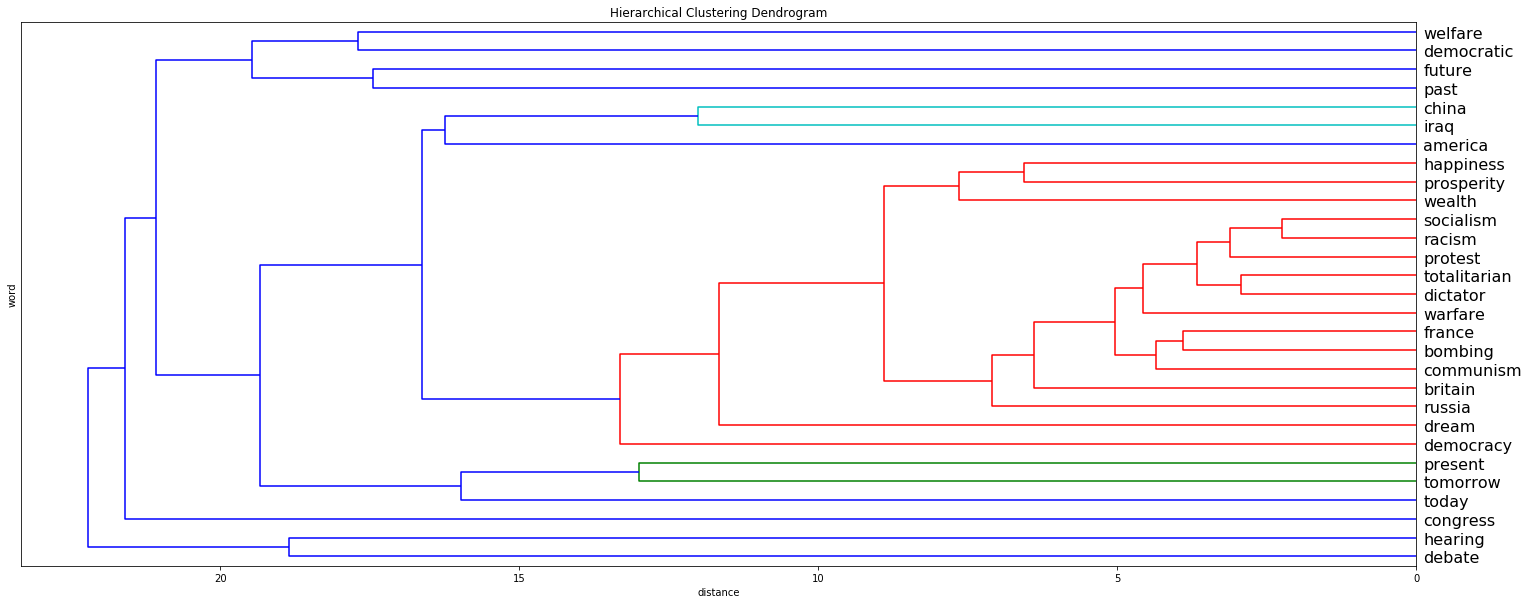

In [64]:
from matplotlib import pyplot as plt

l = links

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=16,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(keywords[v])
)
plt.show()


With a little tweaking, you can create a list of only those vectors for the words most of interest to you, using GENSIM to visualize their similarity to each other in the corpus.

You could even -- like Connell's blog entry indicates -- create a separate dendrogram for 1985 and another for 2005, to see how these terms have changed.

## Subtracting Vectors

You'll recall that we've used vector subtraction before.  Subtracting the context for "woman" from the context for "man" produces a vector of high scores for the words that only appear around "man" but not woman.

In [65]:
diff = congress_model.wv['man'] - congress_model.wv['woman']
congress_model.wv.similar_by_vector(diff)

[('man', 0.6464946269989014),
 ('partisanship', 0.40714409947395325),
 ('equalizer', 0.39473310112953186),
 ('humor', 0.38593071699142456),
 ('guy', 0.38314950466156006),
 ('fondness', 0.37807124853134155),
 ('intellect', 0.37633442878723145),
 ('wisdom', 0.37185099720954895),
 ('admiration', 0.36814337968826294),
 ('rhetoric', 0.3679567575454712)]

In [66]:
diff = congress_model.wv['woman'] - congress_model.wv['man']
congress_model.wv.similar_by_vector(diff)

[('centers', 0.43730899691581726),
 ('hospitals', 0.42092177271842957),
 ('clinics', 0.41291335225105286),
 ('comparable', 0.40121766924858093),
 ('reimbursements', 0.39494556188583374),
 ('medicaid', 0.38980185985565186),
 ('underserved', 0.3892444372177124),
 ('nationwide', 0.38678205013275146),
 ('surveyed', 0.3783349394798279),
 ('childcare', 0.3769303262233734)]

### Visualizing Abstract Relatedness

The four words making up the analogy can be understood as points in space where each word represents a single point. These points represent words' relationships with one-another.

Let's borrow more of Sinykin's code to visualize the results.

In [67]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [68]:
#%matplotlib inline

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

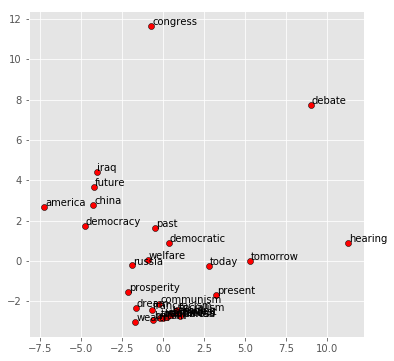

In [69]:
display_pca_scatterplot(congress_model.wv, keywords)

Truth be told, I don't love this visualization; it's visualizing abstract relationships that show the conceptual distance between different entities in the model. I present it to you as a cute toy, not as an approved visualization that i'd like to see in your work. 

Please use PCA analysis with care; it's almost impossible to get back to what it actually *means* -- at least without pairing it with other visualizations and measures.

## Comparing Time with GENSIM

You might recall that there's a lot of data that we're not using, for instance, the 5yrperiod field:

In [70]:
sample_m

,speech,5yrperiod
7260,Mr. President. I thank the chairman and rankin...,1985.0
123139,The joint resolution is before the Senate and ...,1985.0
1080514,Mr. President. I would like to speak on the am...,1995.0
383655,Program shall be comprised of diverse undertak...,1985.0
1194345,I think one of the things that the Senator sai...,1995.0
...,...,...
1833228,The clerk will report the bill by title.,2000.0
992427,Mr. President. today is kind of a sorry day fo...,1990.0
675011,Mr. Speaker. today I am introducing legislatio...,1990.0
2092201,Madam Speaker. I do have another bill that has...,2005.0


How can we make use of it?  How about a for loop?

In [71]:
periodnames = sample_m['5yrperiod'].unique().tolist()
periodnames

[1985.0, 1995.0, 1990.0, 2005.0, 2000.0, 2010.0]

This might take a while, since we're creating 6 different gensim models. Fortunately, we're saving all of them, so if you want to go back and run this for a different word later, you can just load the old data rather than running the whole thing again.

In [72]:
women_context = [] # create an empty dummy variable

for period1 in periodnames:
    period_data = sample_m[sample_m['5yrperiod'] == period1] # select one period at a time
    print('mining ', period1)
    sentences = make_sentences(sample_m['speech']).copy() # break data into sentences for that period only 
    ####### tweak here after the first run to use the old data without generating it again
    period_model = gensim.models.Word2Vec( # make a gensim model for that data
        sentences = sentences,
        min_count = 2, 
        size = 100)  
    period_model.save('model-' + str(period1)) # save the model with the name of the period
    #period_model = gensim.models.Word2Vec.load('model-' + str(period1)) # to load a saved model
    ###########
    women_context_period = period_model.wv.most_similar("woman", topn = 1000) # extract the context of how women were talked about in that period
    women_context.append(women_context_period) # save the context of how women were talked about for later

mining  1985.0
mining  1995.0
mining  1990.0
mining  2005.0
mining  2000.0
mining  2010.0


The output should be a list of context vectors for each period, which we can use to show how the context of 'woman' was changing from period to period.

In [73]:
women_context[0][0:15]

[('person', 0.812820553779602),
 ('man', 0.794691264629364),
 ('soldier', 0.7913120985031128),
 ('citizen', 0.7388914823532104),
 ('parent', 0.7172437310218811),
 ('mother', 0.6989061832427979),
 ('girl', 0.6837268471717834),
 ('lawyer', 0.6664104461669922),
 ('politician', 0.6404123306274414),
 ('son', 0.6247303485870361),
 ('guy', 0.6230310797691345),
 ('lady', 0.622456967830658),
 ('boy', 0.6144431233406067),
 ('doctor', 0.612589955329895),
 ('hero', 0.6057002544403076)]

In [74]:
women_context[5][0:15]

[('soldier', 0.8015145063400269),
 ('person', 0.797299861907959),
 ('man', 0.7911032438278198),
 ('girl', 0.7129052877426147),
 ('citizen', 0.703234076499939),
 ('mother', 0.7024791240692139),
 ('parent', 0.6889504194259644),
 ('lawyer', 0.6750119924545288),
 ('boy', 0.6731034517288208),
 ('son', 0.6396119594573975),
 ('politician', 0.6246641278266907),
 ('hero', 0.6150985956192017),
 ('father', 0.6140142679214478),
 ('lady', 0.6123748421669006),
 ('guy', 0.6097108721733093)]

I can grab just the names this way:

In [75]:
[item[0] for item in women_context[1]][:5]

['person', 'man', 'soldier', 'mother', 'citizen']

I can grab just the numbers for any given year (in this case, the second period -- 1990 -- [1]) this way:

In [76]:
[item[1] for item in women_context[1]][:5]

[0.808594822883606,
 0.7955442667007446,
 0.7893877029418945,
 0.7297607660293579,
 0.7059383392333984]

#### Let's annotate the data with how many times women were referred to over time


Recall that we made a nice dataframe of how many times each word appears over a period.

In [95]:
words_per_period2

count
keyword 5yrperiod       
        1985.0     10869
        1990.0     19112
        1995.0     21196
        2000.0     17206
        2005.0     18881
...                  ...
zones   2005.0         1
       1990.0         1
        2000.0         1
        2005.0         1
§       2005.0        14

[75637 rows x 1 columns]

In [93]:
keyword_per_year = words_per_period2[words_per_period2['keyword'=='zones']]
#keyword_per_year[keyword_per_year['5yrperiod'=='1985']]

KeyError: False

#### Visualize it

Make a flattened list of all the words.

In [85]:
all_words = []
for i in range(5):
    words = [item[0] for item in women_context[i]][:10]
    all_words.append(words)

all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

Set up the colors.

In [87]:
from numpy import linspace
from matplotlib import cm
colors = [ cm.jet(x) for x in linspace(.5, 2, 50) ]

Dots and annotations.

In [88]:
%matplotlib inline

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from adjustText import adjust_text

# change the figure's size here
plt.figure(figsize=(5,5), dpi = 200)

# plt.annotate only plots one label per iteration, so we have to use a for loop 
for i in range(len(periodnames)):    # cycle through the period names
    
    xx = periodnames[i]        # on the x axis, plot the period name
    yyy = keyword_per_year[i]  # how many times was the keyword used that year?

    # for each period, one big black dot
    
    plt.scatter(                                           # plot dots
            xx, #x axis
            yyy, # y axis
            linewidth=1, 
            color = 'black',
            s = 10, # dot size
            alpha=0.2)  # dot transparency

                     
                     
    for j in range(10):     # cycle through the first ten words (you can change this variable)
        
        yy = [item[1] for item in women_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
        txt = [item[0] for item in women_context[i]][j]        # grab the name of each collocated word
        colorindex = all_words2.index(txt)                     # this command keeps all dots for the same word the same color
        
        plt.scatter(                                           # plot dots
            xx, #x axis
            yy, # y axis
            linewidth=1, 
            color = colors[colorindex],
            s = 3, # dot size
            alpha=0.8)  # dot transparency

                                                                # make a label for each word
        plt.annotate(
                txt,
                (xx, yy),   
                size = 5,
                color = 'black', 
                alpha=0.8 # i've made the fonts transparent as well.  you could play with color and size if you wanted to. 
            )

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xticks(rotation=90)

# Add titles
plt.title("Word Context Change for 'WOMAN'a Over Time in Congress", fontsize=20, fontweight=0, color='Red')
plt.xlabel("period")
plt.ylabel("similarity of word")



NameError: name 'keyword_per_year' is not defined

<Figure size 1000x1000 with 0 Axes>

## Assignment

Above, we make a dendrogram of a long list of interesting words and their contextual similarity. 

We also use a list of periods to create separate GENSIM models for each period.

You will put these together to create a dendrogram for 1985 and another dendrogram for 1995 and 2005. 

#### Coding exercise
   * Create a list of keywords that you think would be particularly relevant for Congress during this time -- something that might demonstrate historical change in ideas.
        * Using the code above, create a GENSIM model for 1985, 1995, and 2005
        * Using the code above, create an array of vectors for your words for each time period
        * Using the code above, draw a dendrogram of keyword relatedness for the three time periods.
    
#### Interpretation exercise    
   * Write an interpretive paragraph of at least half a page examining what this dendrogram suggests about change over time.  If there's not enough material in your first experiment, tweak the keyword list and try again -- until you have something to say about history.


Turn in your work on Canvas. Do not turn in an ipynb. 